In [1]:
import torch
from torchvision import transforms
from flamingo_pytorch import PerceiverResampler

/home/andrei/anaconda3/envs/mlmi/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torchxrayvision as xrv
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np

# Get a sample of MIMIC-CXR

In [23]:
image_path1 = '/home/andrei/Downloads/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.dcm' 
ds1 = dicom.dcmread(image_path1)
print(f'ds1 shape {ds1.pixel_array.shape}')
report_file = '/home/andrei/TUM/SoSe2022/MLMI/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p10/p10000032/s50414267.txt'
with open(report_file, 'r') as f:
    report = f.readlines()


ds1 shape (3056, 2544)


In [22]:
rep = ''.join(report)
# print(f'{rep}')
import re
rep[(rep.find('FINDINGS:') + 9):rep.find('IMPRESSION:')].replace('\n','')

import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.encode('This is a test', out_type=int)


[]

In [82]:
# img = cv.resize(ds1.pixel_array, (244,244))
# print(f'example: {img}')

In [26]:
# Add color channel
img = ds1.pixel_array[None, :, :]
print(f'{img}')

transform = transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                xrv.datasets.XRayResizer(224),])

img = transform(img)
img = xrv.datasets.normalize(img,maxval=3870)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


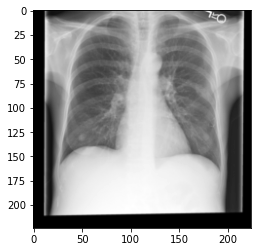

In [25]:
# Show image
plt.imshow(img.squeeze(), cmap='gray')

# Model and image prediction

In [6]:
model = xrv.models.DenseNet(weights="densenet121-res224-mimic_nb")
device = torch.cuda.set_device('cuda:1')

In [7]:
model.eval()

XRV-DenseNet121-densenet121-res224-mimic_nb

In [19]:
# img = torch.from_numpy(img)
# numpy()
# img = torch.nn.Flatten(end_dim=1)(img)
print(f'img: {img[None,:,:,:].shape}')
dout = model(torch.from_numpy(img[None,:,:,:]))

img: (1, 1, 224, 224)


In [20]:
dout

tensor([[0.0307, 0.3362, 0.5000, 0.1200, 0.4051, 0.5000, 0.5000, 0.0201, 0.5027,
         0.5000, 0.0797, 0.5000, 0.5000, 0.5000, 0.5011, 0.1308, 0.3153, 0.0266]])

# Report LM and prediction

In [10]:
from flamingo_pytorch import FlamingoPaLM

In [11]:
flamingo_palm = FlamingoPaLM(
    num_tokens = 20000,          # number of tokens
    dim = 18,                  # dimensions
    depth = 12,                  # depth
    heads = 8,                   # attention heads
    dim_head = 64,               # dimension per attention head
    img_encoder = model,           # plugin your image encoder (this can be optional if you pass in the image embeddings separately, but probably want to train end to end given the perceiver resampler)
    media_token_id = 3,          # the token id representing the [media] or [image]
    cross_attn_every = 3,        # how often to cross attend
    perceiver_num_latents = 16,  # perceiver number of latents, should be smaller than the sequence length of the image tokens
    perceiver_depth = 2          # perceiver resampler depth
)

In [18]:
print(f'report: {report}')
# prepare text
# text_array = torch.from_numpy(np.array(map(int,report)))
rep = ''.join(report)
report = rep[(rep.find('FINDINGS:') + 9):rep.find('IMPRESSION:')]
report

report: ['                                 FINAL REPORT\n', ' EXAMINATION:  CHEST (PA AND LAT)\n', ' \n', ' INDICATION:  ___F with new onset ascites  // eval for infection\n', ' \n', ' TECHNIQUE:  Chest PA and lateral\n', ' \n', ' COMPARISON:  None.\n', ' \n', ' FINDINGS: \n', ' \n', ' There is no focal consolidation, pleural effusion or pneumothorax.  Bilateral\n', ' nodular opacities that most likely represent nipple shadows. The\n', ' cardiomediastinal silhouette is normal.  Clips project over the left lung,\n', ' potentially within the breast. The imaged upper abdomen is unremarkable.\n', ' Chronic deformity of the posterior left sixth and seventh ribs are noted.\n', ' \n', ' IMPRESSION: \n', ' \n', ' No acute cardiopulmonary process.\n']


' \n \n There is no focal consolidation, pleural effusion or pneumothorax.  Bilateral\n nodular opacities that most likely represent nipple shadows. The\n cardiomediastinal silhouette is normal.  Clips project over the left lung,\n potentially within the breast. The imaged upper abdomen is unremarkable.\n Chronic deformity of the posterior left sixth and seventh ribs are noted.\n \n '

In [13]:
print(img[None,:,:,:].shape)

(1, 1, 224, 224)


In [14]:
# palm_logits = flamingo_palm(torch.from_numpy(np.array(map(int,report))))

# after much training off the regular PaLM logits
# now you are ready to train Flamingo + PaLM
# by passing in images, it automatically freezes everything but the perceiver and cross attention blocks, as in the paper

dialogue = torch.randint(0, 20000, (1, 512))
# images = torch.randn(4, 2, 1, 244, 244)
print(f'{img[None, None,:,:,:].shape}')


(1, 1, 1, 224, 224)


In [16]:
flamingo_logits = flamingo_palm(dialogue, torch.from_numpy(img[None, None,:,:,:]))

In [17]:
flamingo_logits.shape

torch.Size([1, 512, 20000])

In [18]:
flamingo_logits

tensor([[[ 0.0041, -0.1069, -0.0069,  ..., -0.0273,  0.1122,  0.1194],
         [ 0.0114, -0.1506, -0.0016,  ..., -0.0311,  0.0826,  0.1161],
         [ 0.0065, -0.1565,  0.0063,  ..., -0.0425,  0.0972,  0.0972],
         ...,
         [ 0.1077, -0.0250,  0.0452,  ...,  0.0340,  0.0634, -0.1662],
         [ 0.1127, -0.0220,  0.1000,  ...,  0.0491,  0.0607, -0.1866],
         [ 0.0946, -0.0289,  0.0909,  ...,  0.0144,  0.0716, -0.1683]]],
       grad_fn=<UnsafeViewBackward0>)